<div style="text-align: left; background-color:#FFFFCC; font-family:Arial; color:#526085; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: dark green;">ĐỒ ÁN THỰC HÀNH</div>
<div style="text-align: left; background-color:#99FFFF; font-family: Arial; color:#551184; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 18px">Bộ môn: Nhập môn Khoa học Dữ liệu | Nhóm 8</div>

# <div style="text-align: left; background-color:#0C6A86; font-family:Arial; color:white; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 30px;border-style: solid;border-color: black;">PHẦN 3. MÔ HÌNH HÓA DỮ LIỆU</div>

## Import các thư viện cần thiết

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

import warnings  # Để loại bỏ các warning
warnings.filterwarnings("ignore")

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Chuẩn bị dữ liệu

In [2]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('./Data/air_quality_cleaned.csv')

# Xem mẫu dữ liệu
data.head()

,dt,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2021-01-01 00:00:00,3,700.95,0.44,35.99,17.35,32.90,20.33,26.64,8.99
1,2021-01-01 01:00:00,3,847.82,2.46,38.04,18.06,36.24,23.32,30.54,9.37
2,2021-01-01 02:00:00,3,894.55,5.25,38.39,23.25,41.01,24.16,31.93,9.25
3,2021-01-01 03:00:00,3,827.79,6.20,36.33,33.98,43.39,23.20,30.91,8.61
4,2021-01-01 04:00:00,2,660.90,3.69,29.13,54.36,35.76,19.50,25.60,6.21


In [3]:
# Kiểm tra thông tin cơ bản về dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25176 entries, 0 to 25175
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dt      25176 non-null  object 
 1   aqi     25176 non-null  int64  
 2   co      25176 non-null  float64
 3   no      25176 non-null  float64
 4   no2     25176 non-null  float64
 5   o3      25176 non-null  float64
 6   so2     25176 non-null  float64
 7   pm2_5   25176 non-null  float64
 8   pm10    25176 non-null  float64
 9   nh3     25176 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.9+ MB


## Bài toán đặt ra

Phân loại chỉ số `aqi` dựa trên các chỉ số nồng độ các chất ô nhiểm `no, co, so2, no2, o3, pm2_5, pm10, nh3`

## Huấn luyện mô hình

**Lựa chọn thuộc tính:** chúng em sẽ tiến hành phân loại chất lượng không khí theo chỉ số `aqi` dựa trên các chỉ số `no, co, so2, no2, o3, pm2_5, pm10, nh3`

In [4]:
# Chia dữ liệu thành features (X) và target variable (y)
X = data[['no', 'co', 'so2', 'no2', 'o3', 'pm2_5', 'pm10', 'nh3']]  # Chọn các chỉ số khí quyển làm features
y = data['aqi']  # Chọn cột AQI làm target variable

**Feature Scaling:**

- Khi khoảng giá trị giữa 2 thuộc tính quá cách xa nhau thì việc mô hình hóa cũng như trực quan mối quan hệ có thể gặp khó khăn, do đó phải thực hiện kĩ thuật 'Feature Scaling' hay việt hóa là 'Co giãn thuộc tính'.
- Có 3 phương pháp feature scaling chính là:
    - Standardisation (Chính quy hóa): Làm cho tập dữ liệu có trung bình là 0 và độ lệch chuẩn là 1 và được áp dụng cho hầu hết các trường hợp cần feature scaling.
    - Normalisation (Tiêu chuẩn hóa): Làm cho các giá trị trong tập dữ liệu thuộc đoạn [0, 1] và được áp dụng nếu tập dữ liệu tuân theo phân phối chuẩn.
    - MinMax Scaler: Đưa các giá trị về khoảng giữa 2 giá trị min và max trong miền giá trị của thuộc tính, có thể là đoạn [-1, 0], [0, 1], [-1, 1],...
- Trong bài này nhóm chọn phương pháp Standardisation để scaling khoảng giá trị của thuộc tính về khoảng gần hơn với giá trị của tập y là `aqi`.

In [5]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Phân tách bộ dữ liệu thành 3 tập training set, validation set và test set:**

- Mục đích:
    - Huấn luyện và đánh giá độc lập: Tập huấn luyện được sử dụng để huấn luyện mô hình. Tập kiểm tra được sử dụng để đánh giá hiệu suất tổng quát của mô hình. Dữ liệu này không được sử dụng trong quá trình huấn luyện để đảm bảo mô hình có khả năng tổng quát hóa với dữ liệu mới, đảm bảo tính khách quan.
    - Kiểm tra: Tập validation được sử dụng để tìm ra mô hình tốt nhất với những siêu tham số khác nhau.
    - Tránh overfitting: Nếu không chia dữ liệu mà sử dụng toàn bộ dữ liệu để huấn luyện, mô hình có thể học "quá khớp" (overfit) dữ liệu huấn luyện mà không tổng quát hóa được cho dữ liệu mới. Việc có tập kiểm tra giúp đánh giá xem mô hình có đang học từ dữ liệu một cách tổng quát hay chỉ học "nhớ" dữ liệu huấn luyện không.
    - Đánh giá và cải thiện mô hình: Thông qua việc đánh giá trên tập kiểm tra, chúng ta có thể đánh giá hiệu suất của mô hình và cải thiện nó thông qua việc điều chỉnh các tham số hoặc phương pháp huấn luyện.
- Kích thước mỗi tập như sau:
    - Size of Training set = 80% * (Size of Dataset)
    - Size of Test set = 20% * (Size of Dataset).

In [6]:
# Chia dữ liệu thành tập train và tập test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Mô hình Decision Tree

- Mô hình Decision Tree (cây quyết định) là một thuật toán học máy có cấu trúc dạng cây, chia dữ liệu dựa trên các quy tắc quyết định đơn giản. Mỗi nút lá của cây đại diện cho một nhãn hoặc một giá trị dự đoán, trong khi các nút gốc và nội bộ biểu diễn các quy tắc quyết định để chia tách dữ liệu.

- Cách hoạt động chính của Decision Tree:

    - Chọn thuộc tính quan trọng: Các thuộc tính được chọn dựa trên độ quan trọng của chúng trong việc chia dữ liệu.
    - Tách nút (node splitting): Mỗi nút trong cây đại diện cho một thuộc tính và một ngưỡng (threshold). Dữ liệu được chia thành các nhánh dựa trên giá trị của thuộc tính này.
    - Xây dựng cây: Quá trình tách nút được thực hiện đệ quy cho đến khi một điều kiện dừng được đáp ứng (như đạt đến độ sâu tối đa hoặc không thể chia tách thêm).

**Tiến hành huấn luyện:**

- Đầu tiên, Nhóm tiến hành mô hình hóa dữ liệu theo *Decision Tree* với một cây khá đơn giản dựa theo thuật toán đo lường *Gini*, *độ sâu tối đa của cây* là 3, *số mẫu tối thiểu cần thiết để chia một node* là 2 và *số mẫu tối thiểu cần thiết ở mỗi leaf* là 1. 
- Sau đó đánh giá mô hình này dựa trên *Cross-validation* bằng cách chia tập train thành 5 phần bằng nhau và sử dụng 4 phần để huấn luyện và phần còn lại để đánh giá mô hình, quá trình này được lặp lại 5 lần, mỗi lần sử dụng một fold khác nhau làm tập kiểm tra. Điều này nhằm thử nghiệm tính hiệu quả của cây đơn giản này với bộ dữ liệu mà chúng em có.  

In [7]:
# Khởi tạo mô hình Decision Tree
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=2, min_samples_leaf=1)

# Huấn luyện mô hình trên tập train
tree_model.fit(X_train, y_train)

# Đánh giá mô hình bằng cross-validation trên tập train
cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Đánh giá mô hình trên tập test (đánh giá cuối cùng)
test_accuracy = tree_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Cross-Validation Scores: [0.80635551 0.81330685 0.80685204 0.80983118 0.80362463]
Mean CV Accuracy: 0.8079940417080437
Test Accuracy: 0.8105639396346307


#### Đánh giá:

- Có thể thấy việc chia tập train thành 5 fold và sử dụng Cross-Validation cho ra hiệu quả khá tương đồng nhau (Trung bình xấp xỉ 80%). Hiệu quả trên tập test ban đầu cũng khá tương tự như vậy (Xấp xỉ 81%). Kết quả này là khá cao, như vậy ta có thể thấy mô hình này khá hiệu quả.

Để có thể hiểu hơn về kết quả, chúng em tiến hành phân tích dữ liệu từ kết quả của mô hình được thực hiện thông qua ma trận nhầm lẫn (confusion matrix) và báo cáo phân loại (classification report):
- Ma trận nhầm lẫn:
    - Ma trận nhầm lẫn giúp xác định độ chính xác và hiệu suất của mô hình trên từng lớp.
    - Các hàng của ma trận đại diện cho lớp thực tế, trong khi các cột đại diện cho lớp được dự đoán.
    - Số lượng điểm dữ liệu nằm trên đường chéo chính (từ trái trên xuống phải dưới) thể hiện số lượng dự đoán đúng.
- Báo cáo phân loại:
    - Báo cáo phân loại cung cấp các chỉ số chính như precision, recall, và F1-score cho từng lớp.
    - Precision: Tỷ lệ số điểm dự đoán đúng trong số tất cả các điểm được dự đoán là thuộc lớp đó.
    - Recall: Tỷ lệ số điểm dự đoán đúng trong số tất cả các điểm thực tế là thuộc lớp đó.
    - F1-score: Trung bình điều hòa giữa precision và recall. F1-score = 2 * (precision * recall) / (precision + recall).
    - Support: Số lượng điểm dữ liệu thực tế trong từng lớp.
- Hiển thị ma trận nhầm lẫn bằng heatmap:
    - Heatmap là một biểu đồ màu sắc giúp hiển thị ma trận nhầm lẫn dưới dạng hình ảnh.
    - Các giá trị càng cao (màu càng đậm) thể hiện số lượng dự đoán đúng càng nhiều.

Ma trận nhầm lẫn:
[[   0  139    0    0    0]
 [   0  798  152    0    0]
 [   0   21  270  448    0]
 [   0    3    7  987  180]
 [   0    0    0    4 2027]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       139
           2       0.83      0.84      0.84       950
           3       0.63      0.37      0.46       739
           4       0.69      0.84      0.75      1177
           5       0.92      1.00      0.96      2031

    accuracy                           0.81      5036
   macro avg       0.61      0.61      0.60      5036
weighted avg       0.78      0.81      0.79      5036



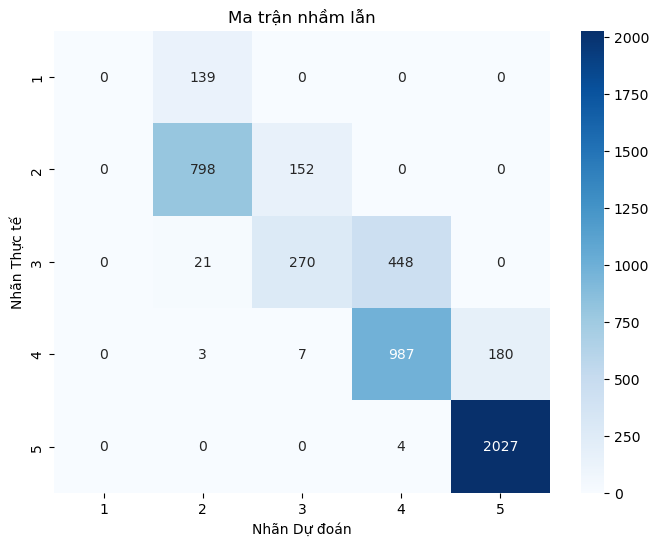

In [8]:
# Dự đoán trên tập test
y_pred_tree = tree_model.predict(X_test)

# Đánh giá mô hình
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_tree))

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_tree))

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt="d", cmap="Blues",
            xticklabels=tree_model.classes_, yticklabels=tree_model.classes_)
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Nhãn Dự đoán")
plt.ylabel("Nhãn Thực tế")
plt.show()

#### Phân tích Kết Quả:

- Chất lượng Tốt (Lớp 1):
    - Precision và Recall đều bằng 0, tức là mô hình dự đoán sai ở lớp này.
- Chất Lượng Trung Bình (Lớp 2):
    - Precision và Recall đều tốt (0.83 và 0.84), cho thấy mô hình có hiệu suất tốt trên lớp này.
- Chất Lượng Kém Đến Rất Kém (Lớp 3):
    - Precision ở mức khá (0.63) nhưng Recall thấp (0.37), cho thấy khả năng dự đoán đúng trên lớp này không cao.
- Chất Lượng Rất Kém Đến Tệ (Lớp 4):
    - Precision và Recall khá tốt (0.69 và 0.84), nhưng có thể được cải thiện.
- Chất Lượng Rất Tệ (Lớp 5):
    - Precision và Recall rất cao (0.93), chỉ ra mô hình tốt trong việc dự đoán chất lượng không khí rất tệ.
    
**=> Giữa các lớp có sự chênh lệch về độ chính xác, điều này đặc biệt rõ với lớp 1 và lớp 5. Nguyên nhân có thể do sự phân bố không đều giữa số lượng dữ liệu của các lớp (dữ liệu thu thập được tập trung ở lớp 5 và ít có dữ liệu ở lớp 1)**

**Cải thiện mô hình:**

- Mô hình có thể hoạt động tốt hơn bằng cách cắt tỉa lại cây (pruning). Quá trình cắt tỉa cây trong mô hình cây quyết định là quá trình loại bỏ một số nhánh hoặc lá của cây để cải thiện tính tổng quát của mô hình. Mục tiêu là loại bỏ các phần của cây mà không cung cấp nhiều thông tin hoặc góp phần vào overfitting.
- Cách thức hoạt động:
    - Tạo một cây quyết định ban đầu: Bước đầu tiên là xây dựng một cây quyết định hoàn chỉnh trên dữ liệu huấn luyện.
    - Tính toán chi phí-phức tạp: Sử dụng thuật toán Cost-Complexity Pruning (CCP) để đánh giá chi phí của mỗi phần tử trong cây (các nhánh hoặc lá). CCP tính toán một giá trị phức tạp cho mỗi nút trong cây, thông qua việc kết hợp giá trị chi phí với độ sâu của nút.
    - Lựa chọn giá trị alpha: Từ đường cong chi phí-phức tạp, chúng ta thu được một chuỗi các giá trị alpha, là các giá trị ngưỡng mà việc cắt tỉa cây sẽ dừng lại. Giá trị alpha được chọn dựa trên một tiêu chí nào đó như cross-validation hoặc một chiến lược tối ưu hóa khác.
    - Cắt tỉa cây: Với giá trị alpha đã chọn, loại bỏ các nhánh hoặc lá của cây mà có chi phí-phức tạp cao hơn giá trị alpha. Các nhánh này được coi là không cần thiết hoặc không mang lại lợi ích đáng kể cho mô hình. Quá trình cắt tỉa này có thể gây ra mất mát thông tin nhất định nhưng giúp mô hình trở nên đơn giản và tránh overfitting.
    - Huấn luyện lại mô hình: Sau khi cắt tỉa, mô hình được huấn luyện lại trên dữ liệu huấn luyện sử dụng cây cây quyết định mới, đã được cắt tỉa. 
    - Đánh giá và kiểm tra hiệu suất: Mô hình mới sau khi cắt tỉa được đánh giá trên tập dữ liệu kiểm tra để xác định hiệu suất và khả năng tổng quát hóa.

**Pruning**

In [9]:
# Tìm alpha tốt nhất để cắt tỉa cây
path = tree_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Tìm giá trị alpha tốt nhất
best_alpha = ccp_alphas[np.argmax(cv_scores)]

# Cắt tỉa cây theo alpha tốt nhất
pruned_tree_model = DecisionTreeClassifier(criterion='gini', ccp_alpha=best_alpha, random_state=42)
pruned_tree_model.fit(X_train, y_train)

# Đánh giá mô hình cắt tỉa trên tập test
test_accuracy_pruned = pruned_tree_model.score(X_test, y_test)
print(f'Test Accuracy of Pruned Tree: {test_accuracy_pruned}')

Test Accuracy of Pruned Tree: 0.8379666401906275


- Mô hình có thể cho ra những kết quả tốt hơn với những tham số khác, vì vậy ta có thể kiểm tra thông qua thư viện **GridSearchCV**
- Các siêu tham số có thể ảnh hưởng tới mô hình:
    - max_depth (Độ sâu tối đa của cây): Điều chỉnh độ sâu tối đa có thể kiểm soát độ phức tạp của cây. Độ sâu càng lớn, mô hình có khả năng học được các mẫu cụ thể hơn trong dữ liệu huấn luyện. Nếu max_depth quá lớn, có thể dẫn đến overfitting. Nếu quá nhỏ, mô hình có thể không học được quy luật của dữ liệu.
    - min_samples_split (Số lượng mẫu tối thiểu để chia nút): Quyết định số lượng mẫu tối thiểu cần phải có trong mỗi nút để tiếp tục chia. Giá trị nhỏ có thể dẫn đến overfitting vì mô hình sẽ cố gắng học mọi chi tiết nhỏ của dữ liệu. Giá trị lớn có thể làm giảm tính tổng quát của mô hình.
    - min_samples_leaf (Số lượng mẫu tối thiểu trên mỗi lá): Xác định số lượng mẫu tối thiểu được yêu cầu ở mỗi lá của cây. Giá trị nhỏ có thể dẫn đến overfitting. Giá trị lớn có thể làm giảm độ chính xác của mô hình.
    - criterion (Tiêu chí chia nút): Xác định phương pháp đo lường chất lượng của phân chia nút. 'gini' và 'entropy' là hai tiêu chí phổ biến. 'gini' tập trung vào việc giảm độ không thuần khiết của các lớp, 'entropy' tập trung vào việc giảm độ không chắc chắn của dự đoán.

**GridSearchCV**

In [10]:
"""
    Sử dụng cách chia tập train và tập test lần lượt là 80% và 20% của dataset, sau đó cũng sử dụng Cross-validation chia tập train thành 4 fold như trên
"""

# Chia dữ liệu thành tập train và tập test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình Decision Tree
dtree = DecisionTreeClassifier()

# Định nghĩa lưới các giá trị tham số cần tìm kiếm
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

# Tạo đối tượng GridSearchCV
tree_grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')

# Thực hiện tìm kiếm trên lưới tham số
tree_grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", tree_grid_search.best_params_)

# In ra độ chính xác tốt nhất trên tập kiểm tra
print("Best Accuracy:", tree_grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.8354021847070505


Như vậy ta đã có thông số params tốt nhất có thể tìm được trong tập các params đưa ra như trên, ta sẽ lưu lại thành `best_model` và đánh giá nó

In [11]:
# Đánh giá hiệu suất của mô hình tốt nhất trên tập kiểm tra
best_model_tree = tree_grid_search.best_estimator_
y_pred = best_model_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8387609213661636


**Dự đoán:**
- Tiến hành dự đoán từ 1 sample data với `best_model_tree` vừa tạo ra như trên

In [12]:
# Tạo sample data mới
new_data = {
    'no': 0.5,
    'co': 700.3,
    'so2': 35.1,
    'no2': 37.3,
    'o3': 52.7,
    'pm2_5': 19.5,
    'pm10': 20.2,
    'nh3': 7.99
}

# Chuyển sample data thành Dataframe
new_df = pd.DataFrame([new_data])

# Chuẩn hóa sample data
new_sample = scaler.transform(new_df)

# Dữ đoán aqi sử dụng best_model vừa huấn luyện trên 
predicted_aqi = best_model_tree.predict(new_sample)

print(f'Predicted AQI: {predicted_aqi}')

Predicted AQI: [2]


### 2. Mô hình SVM
Mô hình SVM (Support Vector Machine) là một thuật toán học có giám sát được sử dụng chủ yếu cho các vấn đề phân loại và hồi quy. SVM tập trung vào việc tìm một đường ranh giới phân chia tốt nhất giữa các lớp dữ liệu.

Cách hoạt động của SVM:
   1. Tìm đường ranh giới (Decision Boundary):

    Với dữ liệu đa chiều, SVM cố gắng tìm ra một đường ranh giới (hyperplane) phân chia các điểm dữ liệu thành các lớp khác nhau. Đối với các bài toán phân loại hai lớp, đường ranh giới này là một đường thẳng. Trong không gian cao chiều, nó là một siêu phẳng (hyperplane).
   2. Tối ưu hóa ranh giới:

    SVM cố gắng tìm ra ranh giới tối ưu nhất bằng cách chọn đường ranh giới sao cho khoảng cách từ điểm dữ liệu gần nhất đến đường ranh giới là lớn nhất có thể. Các điểm gần nhất với đường ranh giới được gọi là các vector hỗ trợ (support vectors).
   3. Kernel Trick:

    SVM có khả năng áp dụng các kernel (hàm kernel) để tạo ra các đường ranh giới phân chia phi tuyến. Điều này cho phép SVM hoạt động tốt trên dữ liệu không thể phân chia tuyến tính một cách đơn giản.
Đặc điểm của SVM:
   - Hiệu suất tốt trong không gian cao chiều: SVM hoạt động tốt trong các không gian đặc trưng có số chiều lớn.
   - Hạn chế với dữ liệu lớn: SVM có thể tốn nhiều tài nguyên tính toán khi xử lý dữ liệu lớn.
   - Có thể chịu ảnh hưởng từ các siêu tham số: Các siêu tham số như kernel, C (tham số điều chuẩn) có thể ảnh hưởng đến hiệu suất của mô hình.
   

**Tiến hành huấn luyện:**

- Tạo một mô hình SVM với C=1.0, là giá trị mặc định thường được sử dụng và random_state=42 để đảm bảo tính tái sử dụng của quá trình huấn luyện.

In [13]:
# Tạo một mô hình SVM
# mô hình SVM được tạo với C=1.0, là giá trị mặc định thường được sử dụng 
# và random_state=42 để đảm bảo tính tái sử dụng của quá trình huấn luyện.
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# Huấn luyện mô hình
svm_model.fit(X_train, y_train)
# Đánh giá mô hình bằng cross-validation trên tập train
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Đánh giá mô hình trên tập test (đánh giá cuối cùng)
test_accuracy = svm_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Cross-Validation Scores: [0.78848064 0.78798411 0.78798411 0.78823237 0.79121152]
Mean CV Accuracy: 0.7887785501489573
Test Accuracy: 0.7821683876092137


#### Đánh giá:

- Có thể thấy việc chia tập train thành 5 fold và sử dụng Cross-Validation cho ra hiệu quả khá tương đồng nhau (Trung bình xấp xỉ 79%). Hiệu quả trên tập test ban đầu cũng khá tương tự như vậy (Xấp xỉ 78%). Kết quả này là khá cao, như vậy ta có thể thấy mô hình này khá hiệu quả.

Để hiểu hơn về kết quả, chúng em cũng xem xét đến ma trận nhầm lẫn và báo cáo phân loại như mô hình trước

Ma trận nhầm lẫn:
[[  94   45    0    0    0]
 [   3  845  102    0    0]
 [   0  120  294  325    0]
 [   0    1  222  812  142]
 [   0    0    0  137 1894]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       0.97      0.68      0.80       139
           2       0.84      0.89      0.86       950
           3       0.48      0.40      0.43       739
           4       0.64      0.69      0.66      1177
           5       0.93      0.93      0.93      2031

    accuracy                           0.78      5036
   macro avg       0.77      0.72      0.74      5036
weighted avg       0.78      0.78      0.78      5036



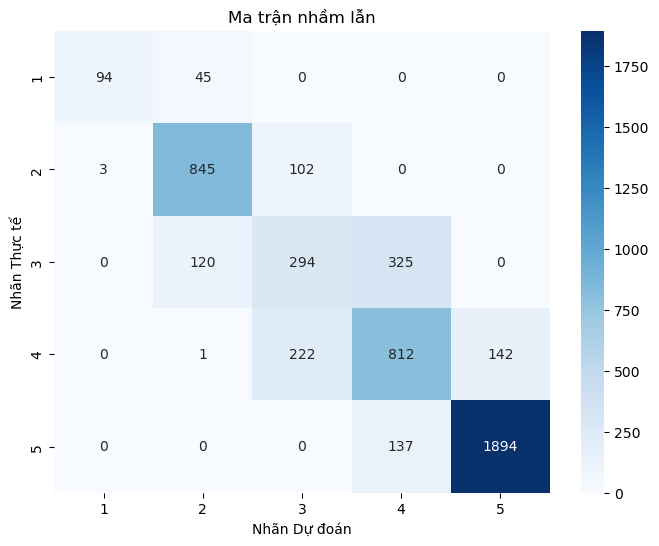

In [14]:
# Dự đoán trên tập test
y_pred_svm = svm_model.predict(X_test)

# Đánh giá mô hình
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nBáo cáo phân loại:")
print(classification_report(y_test,y_pred_svm))

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Blues",
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Nhãn Dự đoán")
plt.ylabel("Nhãn Thực tế")
plt.show()

#### Phân tích Kết Quả:

- Chất lượng Tốt (Lớp 1):
    - Precision cao (0.97) nhưng Recall thấp (0.68) có thể chỉ ra mô hình ít khi dự đoán sai chất lượng không khí tốt, nhưng nó bỏ lỡ nhiều trường hợp thực tế.
- Chất Lượng Trung Bình (Lớp 2):
    - Precision và Recall đều tốt (0.84 và 0.89), cho thấy mô hình có hiệu suất tốt trên lớp này.
- Chất Lượng Kém Đến Rất Kém (Lớp 3):
    - Precision thấp (0.48) và Recall cũng thấp (0.40), cho thấy khả năng dự đoán đúng trên lớp này không cao.
- Chất Lượng Rất Kém Đến Tệ (Lớp 4):
    - Precision và Recall khá tốt (0.64 và 0.69), nhưng có thể được cải thiện.
- Chất Lượng Rất Tệ (Lớp 5):
    - Precision và Recall rất cao (0.93), chỉ ra mô hình tốt trong việc dự đoán chất lượng không khí rất tệ.
    
**=> Mô hình có độ chính xác tổng thể là 78%**

Để cải thiện mô hình và tinh chỉnh siêu tham số C, ta có thể sử dụng **GridSearchCV** từ thư viện scikit-learn.

In [15]:
# Tạo một mô hình SVM
svm = SVC(kernel='linear', random_state=42)

# Định nghĩa các giá trị C để thử nghiệm
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Tạo một GridSearchCV
svm_grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Huấn luyện GridSearchCV trên dữ liệu
svm_grid_search.fit(X_train, y_train)

# In ra giá trị C tốt nhất được chọn
print("Best C:", svm_grid_search.best_params_['C'])

# In ra độ chính xác tốt nhất trên tập kiểm tra
print("Best Accuracy:", svm_grid_search.best_score_)

Best C: 100
Best Accuracy: 0.7937437934458788


**Dự đoán:**
- Tiến hành dự đoán từ 1 sample data với `best_svm_model` vừa tạo ra như trên

In [16]:
# Sử dụng mô hình đã tinh chỉnh từ GridSearchCV
best_svm_model = svm_grid_search.best_estimator_

# Chuẩn hóa mẫu dữ liệu mới (nếu cần)
new_data = scaler.transform([[0.44, 700.95, 32.90, 35.99, 17.35, 20.33, 26.64, 8.99]])

# Dự đoán AQI cho mẫu dữ liệu mới
predicted_aqi = best_svm_model.predict(new_data)

print(f'Predicted AQI: {predicted_aqi}')

Predicted AQI: [2]


### 3. Mô hình KNN (K-Nearest Neighbors)

Mô hình K-Nearest Neighbors (KNN) hoạt động dựa trên nguyên lý đơn giản: "Nhóm các điểm dữ liệu gần nhau trong không gian đặc trưng sẽ có cùng nhãn hoặc giá trị dự đoán". KNN không học được một mô hình tường minh mà chỉ lưu trữ dữ liệu huấn luyện.

Cách hoạt động:
- Bước huấn luyện:
  - KNN lưu trữ toàn bộ dữ liệu huấn luyện.
- Bước dự đoán:
  - Khi có dữ liệu mới cần dự đoán, KNN tìm k điểm dữ liệu gần nhất với điểm dữ liệu mới trong không gian đặc trưng. K là số lân cận được xác định trước (hyperparameter).

  - KNN sử dụng một phép đo khoảng cách để xác định các điểm gần nhất.
  - Các điểm gần nhất này sẽ đóng vai trò trong việc quyết định nhãn hoặc giá trị dự đoán cho điểm dữ liệu mới. Điều này được thực hiện bằng cách đếm số lượng điểm thuộc mỗi nhóm trong k điểm gần nhất và chọn nhóm chiếm đa số là nhãn hoặc giá trị dự đoán cho điểm dữ liệu mới.

- Trong bài này, mô hình KNN nhóm em sẽ sử dụng phép đo khoảng cách Euclidean để xác định điểm gần nhất.
    - Euclidean là phép đo phổ biến và được sử dụng rộng rãi trong thuật toán KNN.
    - Công thức khoảng cách Euclidean giữa hai điểm $ p $ và $ q $ trong không gian nhiều chiều ($ n $ chiều) được tính bằng căn bậc hai của tổng bình phương của sự khác biệt giữa các thành phần tương ứng của hai điểm.
                    $$ \text{Euclidean distance} = \sqrt{\sum_{i=1}^{n} (q_i - p_i)^2} $$


    - Trong công thức này:
        - $ p $ và $ q $ là hai điểm trong không gian $ n $ chiều.
        - $ p_i $ và $ q_i $ là các thành phần tương ứng của hai điểm $ p $ và $ q $.
        - $ n $ là số chiều của không gian đặc trưng.


**Tiến hành huấn luyện**
- Đầu tiên, nhóm sẽ tiếp cận mô hình KNN với K = 5.
- Sau đó đánh giá mô hình này dựa trên *Cross-validation* bằng cách chia tập train thành 5 phần bằng nhau và sử dụng 4 phần để huấn luyện và phần còn lại để đánh giá mô hình, quá trình này được lặp lại 5 lần, mỗi lần sử dụng một fold khác nhau làm tập kiểm tra. Điều này nhằm thử nghiệm tính hiệu quả của mô hình KNN này với bộ dữ liệu mà chúng em có.  
 

In [17]:
# Tạo mô hình KNN Classifier (ví dụ với k=5)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Huấn luyện mô hình với dữ liệu huấn luyện
knn_model.fit(X_train, y_train)

# Dự đoán nhãn cho dữ liệu kiểm tra
y_pred_knn = knn_model.predict(X_test)

# Đánh giá hiệu suất của mô hình trên tập test
# accuracy = knn_classifier.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7768069896743447


In [18]:
# Đánh giá mô hình bằng cross-validation trên tập train
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.76812314 0.78252234 0.77259186 0.775571   0.76564052]
Mean CV Accuracy: 0.7728897715988083


#### Đánh giá
- Kết quả của mô hình sau khi chia *5 fold* và sử dụng *Cross-Validation* cho ra kết quả khá tương đồng. Trung bình ở *77,29%*, mức này là khá tốt của 1 mô hình

Để hiểu hơn về kết quả, chúng em cũng xem xét đến ma trận nhầm lẫn và báo cáo phân loại như mô hình trước

Ma trận nhầm lẫn:
[[  99   40    0    0    0]
 [  11  837   88   14    0]
 [   0  154  317  261    7]
 [   0   26  228  772  151]
 [   0    0   12  132 1887]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       0.90      0.71      0.80       139
           2       0.79      0.88      0.83       950
           3       0.49      0.43      0.46       739
           4       0.65      0.66      0.66      1177
           5       0.92      0.93      0.93      2031

    accuracy                           0.78      5036
   macro avg       0.75      0.72      0.73      5036
weighted avg       0.77      0.78      0.77      5036



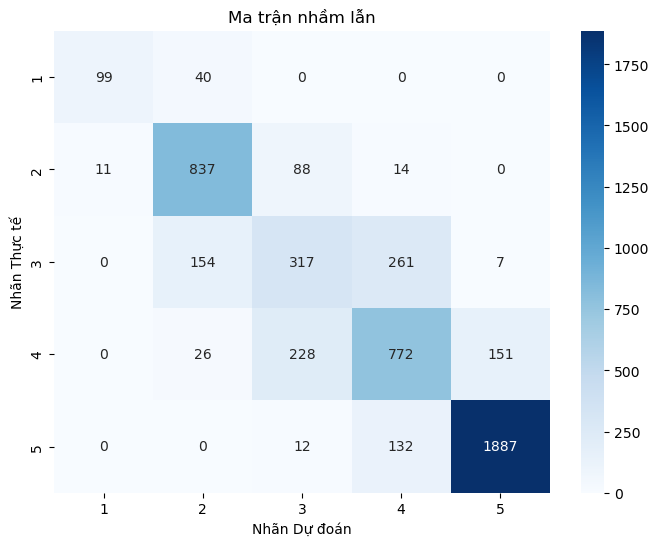

In [19]:
# Đánh giá mô hình
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nBáo cáo phân loại:")
print(classification_report(y_test,y_pred_knn))

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Blues",
            xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Nhãn Dự đoán")
plt.ylabel("Nhãn Thực tế")
plt.show()

#### Phân tích Kết Quả:

- Chất lượng Tốt (Lớp 1):
    - Precision cao (0.9) và Recall ở mức khá (0.71) có thể chỉ ra mô hình ít khi dự đoán sai chất lượng không khí tốt
- Chất Lượng Trung Bình (Lớp 2):
    - Precision và Recall đều tốt (0.79 và 0.88), cho thấy mô hình có hiệu suất tốt trên lớp này.
- Chất Lượng Kém Đến Rất Kém (Lớp 3):
    - Precision thấp (0.49) và Recall cũng thấp (0.43), cho thấy khả năng dự đoán đúng trên lớp này không cao.
- Chất Lượng Rất Kém Đến Tệ (Lớp 4):
    - Precision và Recall khá tốt (0.65 và 0.66), nhưng có thể được cải thiện.
- Chất Lượng Rất Tệ (Lớp 5):
    - Precision và Recall rất cao (0.92 và 0.93), chỉ ra mô hình tốt trong việc dự đoán chất lượng không khí rất tệ.
    
**=> Mô hình có độ chính xác tổng thể là 78%**

**Cải thiện mô hình**
- K có thể ảnh hưởng đến hiện tượng overfitting hoặc underfitting. K càng lớn thì mô hình càng đơn giản nhưng có thể dẫn đến việc bỏ qua các chi tiết nhỏ, trong khi K càng nhỏ thì mô hình có thể trở nên quá phức tạp và dễ bị nhiễu.
- Nhóm sẽ sử dụng **K-Fold Cross-validation** để chia dữ liệu thành các tập con và đánh giá hiệu suất của mô hình với mỗi giá trị K. Điều này giúp chọn được giá trị K phù hợp cho mô hình KNN của nhóm, dựa trên mục tiêu tối ưu hóa hiệu suất và tránh hiện tượng *overfitting/underfitting*. (Có thể sử dụng **GridSearchCV** hoặc **RandomizedSearchCV**)
- Nhóm sẽ thử nghiệm với K=[1:101] để tìm ra K tốt nhất cho tập dữ liệu của nhóm.

**GridSearchCV**

In [20]:
# Tạo mô hình KNN
knn = KNeighborsClassifier()
n_neighbors = [num for num in range(3, 101) if num % 2 != 0]
# Thiết lập các tham số cần tìm kiếm
param_grid = {'n_neighbors': n_neighbors}  # Các giá trị K cần thử

# Sử dụng GridSearchCV để tìm giá trị K tốt nhất
knn_grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train, y_train)

# In ra giá trị K tốt nhất và độ chính xác tương ứng
print("Giá trị K tốt nhất:", knn_grid_search.best_params_)
print("Độ chính xác tốt nhất:", knn_grid_search.best_score_)

Giá trị K tốt nhất: {'n_neighbors': 15}
Độ chính xác tốt nhất: 0.7817279046673287


**K-Fold Cross-Validation**

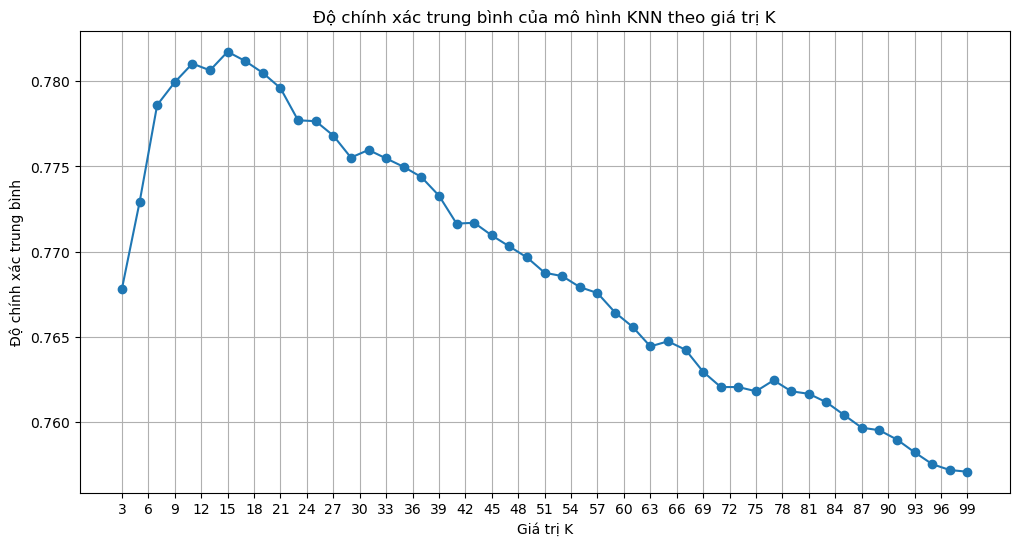

In [21]:
n_neighbors = [num for num in range(3, 101) if num % 2 != 0]

# Để lưu trữ độ chính xác trung bình của mỗi giá trị K
mean_accuracy = []

# Lặp qua từng giá trị K và thực hiện cross-validation
for k in n_neighbors:
    # Tạo mô hình KNN với giá trị K hiện tại
    knn = KNeighborsClassifier(n_neighbors=k)

    # Huấn luyện mô hình với dữ liệu huấn luyện
    knn.fit(X_train, y_train)
    
    # Thực hiện k-fold cross-validation với K hiện tại
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # Sử dụng 5-fold cross-validation
    
    # Accuracy trung bình
    mean_accuracy.append(np.mean(scores))
    
# Vẽ đồ thị độ chính xác trung bình của mỗi giá trị K
plt.figure(figsize=(12, 6))
plt.plot(n_neighbors, mean_accuracy, marker='o')
plt.title('Độ chính xác trung bình của mô hình KNN theo giá trị K')
plt.xlabel('Giá trị K')
plt.ylabel('Độ chính xác trung bình')
plt.grid(True)
plt.xticks(np.arange(min(n_neighbors), max(n_neighbors)+1, 3))  # Chọn các giá trị K mỗi 3 đơn vị
plt.show()

- Như vậy, nhìn vào kết quả *GridSearch* và kết quả từ *K-Fold Cross-Validation* ta thấy K tốt nhất = 15, nếu K lớn hơn hoặc nhỏ hơn độ chính xác đều giảm. Vì vậy không cần kiểm tra với K > 101.
- Lưu lại K=15, đây là model KNN tốt nhất cho tập dữ liệu của nhóm.

In [22]:
# Đánh giá hiệu suất của mô hình tốt nhất trên tập kiểm tra
best_model_knn = knn_grid_search.best_estimator_
y_pred = best_model_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.778196981731533


**Dự đoán**


- Tiến hành dự đoán 1 mẫu với `best_model_knn` trên.

In [23]:
# Tạo sample data mới
new_data = {
    'no': 0.5,
    'co': 700.3,
    'so2': 35.1,
    'no2': 37.3,
    'o3': 52.7,
    'pm2_5': 19.5,
    'pm10': 20.2,
    'nh3': 7.99
}

# Chuyển sample data thành Dataframe
new_df = pd.DataFrame([new_data])

# Chuẩn hóa sample data
new_sample = scaler.transform(new_df)

# Dữ đoán aqi sử dụng best_model vừa huấn luyện trên 
predicted_aqi = best_model_knn.predict(new_sample)

print(f'Predicted AQI: {predicted_aqi}')

Predicted AQI: [2]


### 4. Mô hình Multi-layer neural network

- Mô hình Multi-layer neural network-MLP (mạng nơ-ron nhiều lớp) là một thuật toán học máy có giám sát (Machine Learning) thuộc lớp Mạng nơ-ron nhân tạo, là tập hợp của các perceptron chia làm nhiều nhóm, mỗi nhóm tương ứng với một layer. Thuật toán về cơ bản được đào tạo trên dữ liệu để học một hàm phi tuyến tính nhằm mục đích phân loại hoặc hồi quy, với một tập hợp các tính năng và một biến mục tiêu.
  
- MLP có ba lớp chính:
    - Lớp đầu vào (Input layer): Đây là lớp nhận dữ liệu đầu vào cho mạng. Mỗi nơ-ron trong lớp này nhận một giá trị riêng từ dữ liệu đầu vào.
    - Lớp ẩn (Hidden layer): Nằm giữa lớp đầu vào và lớp đầu ra, có thể có một hoặc nhiều lớp ẩn. Các nơ-ron trong lớp ẩn nhận tín hiệu từ các nơ-ron ở lớp trước, thực hiện một phép tính với tín hiệu đó bằng một hàm kích hoạt (activation function), và gửi kết quả cho các nơ-ron ở lớp tiếp theo.
    - Lớp đầu ra (Output layer): Lớp này cung cấp kết quả của mạng. Số lượng nơ-ron trong lớp đầu ra phụ thuộc vào loại bài toán.


- Cách hoạt động của MLP có thể được mô tả như sau:
    - Dữ liệu đầu vào được đưa vào lớp đầu vào.
    - Các nơ-ron trong lớp ẩn nhận tín hiệu từ các nơ-ron ở lớp trước, thực hiện phép tính với tín hiệu đó bằng hàm kích hoạt và gửi kết quả cho các nơ-ron ở lớp tiếp theo.
    - Quá trình này được lặp lại cho đến khi tín hiệu đến lớp đầu ra.
    - Nơ-ron trong lớp đầu ra cung cấp kết quả cuối cùng của mạng.
 
**Tiến hành huấn luyện:**

- Đầu tiên, nhóm tiến hành xây dựng mô hình MLP với các tham số mặc định: `hidden_layer_sizes=(100,)`, `activation='relu'`, `solver='adam'`.
- Sau đó đánh giá mô hình này dựa trên *Cross-validation* bằng cách chia tập train thành 5 phần bằng nhau và sử dụng 4 phần để huấn luyện và phần còn lại để đánh giá mô hình, quá trình này được lặp lại 5 lần, mỗi lần sử dụng một fold khác nhau làm tập kiểm tra. Điều này nhằm thử nghiệm tính hiệu quả của mô hình MLP này với bộ dữ liệu mà chúng em có.

In [24]:
# Khởi tạo mô hình MLP với các siêu tham số mặc định và max_iter = 50 (số lượng vòng lặp tối đa)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter = 50)

# Huấn luyện mô hình trên tập train
mlp_model.fit(X_train, y_train)

# Đánh giá mô hình bằng cross-validation trên tập train
cv_scores = cross_val_score(mlp_model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Đánh giá mô hình trên tập test
test_accuracy = mlp_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

Cross-Validation Scores: [0.79493545 0.79543198 0.79369414 0.80089374 0.79021847]
Mean CV Accuracy: 0.7950347567030784
Test Accuracy: 0.7877283558379666


**Đánh giá:**
- Việc chia tập train thành 4 fold và sử dụng Cross-Validation cho ra kết quả accuracy khá tương đồng nhau (xấp xỉ 80%).
- Kết quả trên tập test cũng có accuracy xấp xỉ 79%. Kết quả này là khá tốt.

Để hiểu hơn về kết quả, chúng em cũng xem xét đến ma trận nhầm lẫn và báo cáo phân loại như mô hình trước

Ma trận nhầm lẫn:
[[  88   51    0    0    0]
 [   4  873   72    1    0]
 [   0  170  224  344    1]
 [   0    0  187  821  169]
 [   0    0    0   70 1961]]

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       0.96      0.63      0.76       139
           2       0.80      0.92      0.85       950
           3       0.46      0.30      0.37       739
           4       0.66      0.70      0.68      1177
           5       0.92      0.97      0.94      2031

    accuracy                           0.79      5036
   macro avg       0.76      0.70      0.72      5036
weighted avg       0.77      0.79      0.78      5036



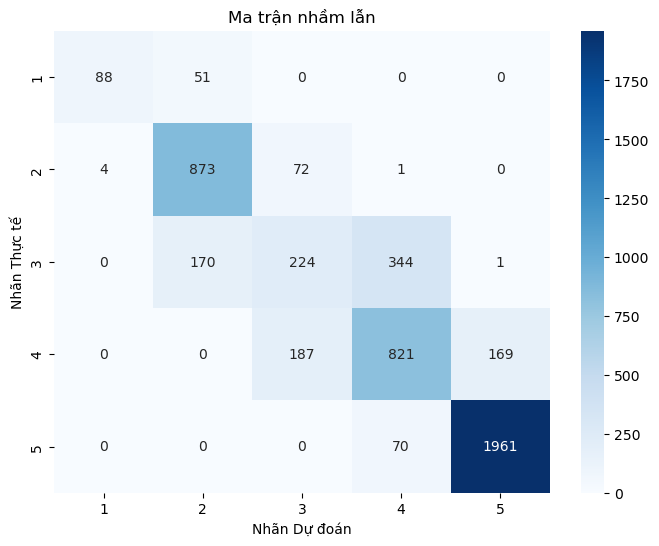

In [25]:
# Dự đoán trên tập test
y_pred_mlp = mlp_model.predict(X_test)

# Đánh giá mô hình
print("Ma trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred_mlp))

print("\nBáo cáo phân loại:")
print(classification_report(y_test,y_pred_mlp))

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt="d", cmap="Blues",
            xticklabels=mlp_model.classes_, yticklabels=mlp_model.classes_)
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Nhãn Dự đoán")
plt.ylabel("Nhãn Thực tế")
plt.show()

#### Phân tích Kết Quả:

- Chất lượng Tốt (Lớp 1):
    - Precision cao (0.96) và Recall thấp (0.64) có thể chỉ ra mô hình ít khi dự đoán sai chất lượng không khí tốt, nhưng nó bỏ lỡ nhiều trường hợp thực tế.
- Chất Lượng Trung Bình (Lớp 2):
    - Precision và Recall đều tốt (0.82 và 0.90), cho thấy mô hình có hiệu suất tốt trên lớp này.
- Chất Lượng Kém Đến Rất Kém (Lớp 3):
    - Precision thấp (0.47) và Recall cũng thấp (0.34), cho thấy khả năng dự đoán đúng trên lớp này không cao.
- Chất Lượng Rất Kém Đến Tệ (Lớp 4):
    - Precision và Recall khá tốt (0.67 và 0.69), nhưng có thể được cải thiện.
- Chất Lượng Rất Tệ (Lớp 5):
    - Precision và Recall rất cao (0.92 và 0.97), chỉ ra mô hình tốt trong việc dự đoán chất lượng không khí rất tệ.
    
**=> Mô hình có độ chính xác tổng thể là 79%**

**Cải thiện mô hình:**
- Các siêu tham có thể ảnh hưởng tới hiệu suất mô hình như sau:
    - Hidden_layer_sizes: quyết định số lượng và kích thước của các lớp ẩn trong mô hình. Số lượng lớp ẩn càng lớn thì mô hình càng có thể học được các mối quan hệ phức tạp hơn trong dữ liệu, nhưng cũng dễ bị overfitting. Kích thước của lớp ẩn càng lớn thì mô hình càng có thể học được các mối quan hệ phức tạp hơn, nhưng cũng cần nhiều dữ liệu hơn để huấn luyện.
    - Activation (Hàm kích hoạt): Hàm kích hoạt quyết định cách thức mà các nơ-ron trong mô hình xử lý thông tin.
    - Solver: quyết định phương pháp tối ưu hóa được sử dụng để cập nhật trọng số và bias của mô hình.

Nhóm sẽ sử dụng ***GridSearchCV*** để cải thiện mô hình và tinh chỉnh các siêu tham số.

In [26]:
# Khởi tạo mô hình MLP với max_iter = 50 (số lượng vòng lặp tối đa)
mlp = MLPClassifier(max_iter = 50)

# Định nghĩa lưới các giá trị tham số cần tìm kiếm
mlp_param_grid = {
    'hidden_layer_sizes': [(100,),(5,10,20),(20,20)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver':['sgd', 'adam'],
}

# Tạo đối tượng GridSearchCV
mlp_grid_search = GridSearchCV(mlp, mlp_param_grid, cv=5, scoring='accuracy')

# Thực hiện tìm kiếm trên lưới tham số
mlp_grid_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
print("Best Parameters:", mlp_grid_search.best_params_)

# In ra độ chính xác tốt nhất trên tập kiểm tra
print("Best Accuracy:", mlp_grid_search.best_score_)

Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (5, 10, 20), 'solver': 'adam'}
Best Accuracy: 0.8102284011916584


Như vậy ta đã có các siêu tham số tốt nhất có thể tìm được trong tập các params đưa ra như trên, ta sẽ lưu lại thành `best_mpl_model` và đánh giá nó

In [27]:
# Đánh giá hiệu suất của mô hình tốt nhất trên tập kiểm tra
best_mlp_model = mlp_grid_search.best_estimator_
y_pred = best_mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8099682287529786


**Dự đoán**
- Tiến hành dự đoán từ 1 sample data với `best_mpl_model` vừa tạo ra như trên

In [28]:
# Tạo sample data mới
new_data = {
    'no': 0.5,
    'co': 700.3,
    'so2': 35.1,
    'no2': 37.3,
    'o3': 52.7,
    'pm2_5': 19.5,
    'pm10': 20.2,
    'nh3': 7.99
}

# Chuyển sample data thành Dataframe
new_df = pd.DataFrame([new_data])

# Chuẩn hóa sample data
new_sample = scaler.transform(new_df)

# Dữ đoán aqi sử dụng best_model vừa huấn luyện trên 
predicted_aqi =  best_mlp_model.predict(new_sample)

print(f'Predicted AQI: {predicted_aqi}')

Predicted AQI: [2]


## Tổng kết

- Với bộ dữ liệu của nhóm, Mô hình cho ra kết quả tốt nhất là mô hình `Decision Tree` với accuracy từ mô hình tốt nhất tìm được là gần 83%. Kết quả này có thể là vì đây là bộ dữ liệu không quá phức tạp với không quá nhiều biến và mối quan hệ giữa các biến không quá phức tạp. Bên cạnh đó với các mô hình còn lại là `SVM`, `KNN`, `MLP` thì độ chính xác cũng ở mức khá cao và chấp nhận được (xấp xỉ 80%).
- Các mô hình có thể phân loại tốt với các mẫu không khí có chất lượng kém và rất kém (aqi = 4,5), tuy nhiên với các mẫu không khí từ bình thường đến tốt thì các mô hình hoạt động vẫn chưa tốt lắm. Điều này có thể đến từ sự phân bố tập trung quá nhiều vào các mẫu có chất lượng kém và rất kém trong bộ dữ liệu thu thập được
- Các yếu tố có thể ảnh hưởng đến mô hình phân loại:
    - Có nhiều yếu tố ngoại cảnh: thời tiết, nhiệt độ, độ ẩm,...
    - Bên cạnh đó, cách đo và thu thập các chỉ số cũng ảnh hưởng lớn đến kết quả của mô hình

Qua quá trình tìm hiểu, nhóm đã có một sự so sánh tổng quan về Decision Tree, MLP (Multi-layer Perceptron), SVM (Support Vector Machine) và KNN (K-Nearest Neighbors) như sau:

1. Decision Tree:
    - Ưu điểm:

        - Dễ hiểu và diễn giải. Có thể trực quan hóa cây quyết định.
        - Khả năng xử lý cả dữ liệu số học và phân loại.
        - Không cần nhiều tiền xử lý dữ liệu, có thể xử lý dữ liệu bị thiếu.
    - Hạn chế:

        - Dễ bị overfitting nếu cây quá sâu và không được cắt tỉa (pruning).
        - Khá nhạy cảm với việc nhận dạng và sửa chữa nhiễu trong dữ liệu.
        - Có thể không hiệu quả khi có quá nhiều biến và mối quan hệ phức tạp.
2. MLP (Multi-layer Perceptron):
    - Ưu điểm:

        - Có khả năng học và ánh xạ các mô hình phức tạp.
        - Phù hợp cho việc học từ dữ liệu phi cấu trúc hoặc phi tuyến tính.
    - Hạn chế:

        - Đòi hỏi nhiều dữ liệu huấn luyện và thời gian huấn luyện lâu.
        - Dễ bị overfitting nếu không kiểm soát được các tham số (ví dụ: số lớp, số nút, hàm kích hoạt, v.v.).
3. SVM (Support Vector Machine):
    - Ưu điểm:

        - Hiệu quả trong không gian chiều cao.
        - Hỗ trợ phân loại tốt khi có ranh giới quyết định rõ ràng giữa các lớp.
        - Có thể sử dụng các hàm nhân (kernel) để ánh xạ dữ liệu vào không gian cao chiều.
    - Hạn chế:

        - Khó áp dụng và tinh chỉnh đối với dữ liệu lớn và không cân bằng.
        - Yêu cầu lựa chọn kernel phù hợp và tinh chỉnh siêu tham số một cách thích hợp.
4. KNN (K-Nearest Neighbors):
    - Ưu điểm:

        - Dễ triển khai và không cần huấn luyện.
        - Hiệu quả với dữ liệu có cấu trúc đơn giản và không có phân cụm rõ ràng.
    - Hạn chế:

        - Độ phức tạp tính toán cao khi có nhiều điểm dữ liệu.
        - Độ chính xác thấp với dữ liệu có nhiều chiều hoặc có nhiều nhiễu.

## Tự đánh giá

| STT | Họ tên | Khó khăn mắc phải | Bài học rút ra |
|---|---|---|---|
| 1 | Hồ Sỹ Kiên | Lần đầu sử dụng git nên còn nhiều bỡ ngỡ, chưa thực sự thành thạo. Tự cảm thấy phần đặt câu hỏi và trả lời chưa thực sự sâu sắc. Code còn hơi dài dòng và chưa thực sự tối ưu. | Giúp làm quen với git và cách làm việc nhóm trên git, cách quản lý và phân chia công việc trên Notion. Biết cách xây dựng một mô hình đơn giản thông qua các dữ liệu đã có. |
| 2 | Hoàng Thành Nam | Chưa có nhiều thời gian cho bài tập. Gặp rắc rối trong việc xử lí các kiểu biểu đồ minh hoạ. | Căn chỉnh thời gian phù hợp.  Học thêm về cách trực quan hóa bằng biểu đồ. |
| 3 | Nguyễn Hoài An | Chưa nắm rõ về các thuật toán để xây dụng mô hình. Code chưa thực sự tối ưu.| Học hỏi thêm về nhiều thuật toán. Biết sử dụng thêm các hàm thư viện có sẵn để tối ưu code. |
| 4 | Đinh Thị Thúy Hường | Chưa nắm rõ về các mô hình.Tự cảm thấy phần đặt câu hỏi và trả lời chưa thực sự sâu sắc, nếu có thời gian sẽ tìm hiểu về dữ liệu nhiều hơn để đưa ra một câu hỏi hay hơn. | Hiểu hơn về dữ liệu, thêm được nhiều kiến thức. |



**Nếu có nhiều thời gian hơn, nhóm em sẽ:**
- Tổ chức nhiều buổi họp hơn để cùng nhau thảo luận, tìm hiểu sâu hơn về thông tin dữ liệu mà nhóm đã thu thập. Từ đó nâng cao hiệu quả làm việc.
- Học cách tiền xử lý dữ liệu kĩ hơn để có thể loại bỏ các dữ liệu gây nhiễu hoặc các dữ liệu không có giá trị về mặt ý nghĩa gây ảnh hưởng đến mô hình học máy.
- Đưa ra các câu hỏi mang tính ý nghĩa, sâu sắc hơn nhằm khai thác triệt để hơn những thông tin mà dữ liệu mng lại.
- Tìm hiểu thêm về các mô hình học máy để tối ưu hơn hiệu quả của các mô hình.
- Hoàn thiện phân chia file notebook, tuân thủ clear-coding, viết code ngắn gọn và đơn
giản nhất có thể, chú thích tường minh cho từng bước xử lý.
- Hoàn thiện hơn slide thuyết trình về mặt nội dung và thẩm mỹ.
